___
<img src="https://www.up.edu.mx/manualgrafico/HRfiles/imagen/escudo_CH001.jpg" width="300"/>

# Videogames Sales Predictions

<center><img src="https://lh3.googleusercontent.com/proxy/4lmlA9rdbpQB-7SWoD9q9vFz3eH736nvAr7pSUrwJx4Gmb2ygtQ0aPpmE38NdrxmnqUGbrlB5M8u4unz2MxhzLe4npHWl_28DkZbzyWVqRwC6lki-3uoujZtBGG1U_eKDR3IqKm_OJDrJHalzUmA" width="70"/></center>

### Team:
|Name|ID|
|---|---|
|Alberto Piñón Formoso|0198073|
|Juan Pablo Zerón del Valle|0195807|
|Oscar Zuñiga Gutierrez|0173882|
|Samir Alejandro Ruiz Mafud|0201187|

### Project description
-- describir el proyecto --

### Objective
-- describir el objetivo--

### Description of the variables
|Rank|Ranking of overall sales|
|---|---|
|Name|The games name|
|Platform|Platform of the games release (i.e. PC, PS4, etc.)|
|Year|Year of the game's release|
|Genre|Genre of the game|
|Publisher|Publisher of the game|
|NA_Sales|Sales in North America (in millions)|
|EU_Sales|Sales in Europe (in millions)|
|JP_Sales|Sales in Japan (in millions)|
|Other_sales|Sales in the rest of the world (in millions)|
|**Global_Sales**|Total worldwide sales|

<br> The objective variable to predict is the *Global_Sales* column. </br>
___

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import graphviz as graph
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.compose import make_column_transformer

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.tree import export_graphviz
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import accuracy_score, plot_confusion_matrix

In [2]:
np.random.seed(42)

In [3]:
df = pd.read_csv('https://bit.ly/2I2oMz4') # Reading the .csv file from github repository
df.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [4]:
# Checking the details of every column and the dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


___
**Exploratory Analysis**

Here we will make an exploratory analysis of the information the dataset is providing to undersand it and begin to take decisions

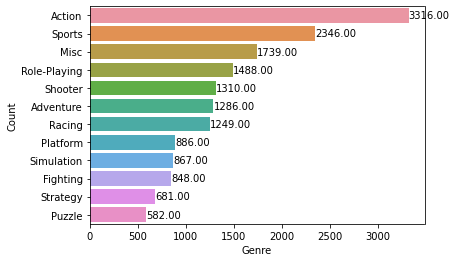

In [5]:
temp = df['Genre'].value_counts().reset_index() # obtaining the quantity of generes to plot the info in descending order
splot = sns.barplot(x=temp['Genre'], y=temp['index'])

# For loop to label each bar of the plot
for p in splot.patches:
  width = p.get_width()
  splot.text(width + 1,
          p.get_y() + p.get_height() / 2,
          '{:1.2f}'.format(width),
          ha='left', va='center')
  
plt.xlabel('Genre') # Setting the x axis label
plt.ylabel('Count') # Setting the y axis label
plt.show();

Here we can observe that the three most produced genre games in the industry are:
1. Action
2. Sports
3. Misc

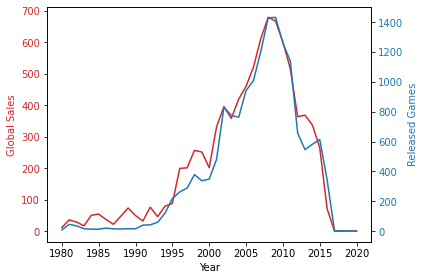

In [6]:
temp = df.groupby('Year').agg({'Year': 'count', 'Global_Sales': 'sum'}) # Grouping the information by year and counting the released games by year for a further plot
temp.rename(columns={'Year': 'Count'}, inplace=True) # renaming the year column se we don't have problems when reseting index
temp.reset_index(inplace=True) 

fig, ax1 = plt.subplots() # Creating a figure for ploting

color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Global Sales', color=color)
ax1.plot(temp['Year'], temp['Global_Sales'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() # Setting a twin y axis so we can have two scales
color = 'tab:blue'
ax2.set_ylabel('Released Games', color=color)
ax2.plot(temp['Year'], temp['Count'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

Here we can observe that the sales of each year is proportional to the released games and the parts where the global sales line (red) is above of the released games line (blue) is where the revenue is great in relation with the released games.
Also we can see a peak on the graph between 2005 and 2010. On this years the production of videogames was higher and also the revenue increased.

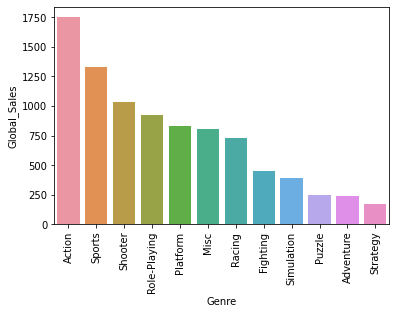

In [7]:
temp = df.groupby('Genre').agg({'Global_Sales': 'sum'}).reset_index() # Grouping by Genre to observe the total revenue of each
temp.sort_values('Global_Sales', axis=0, ascending=False, inplace=True)
splot = sns.barplot(data=temp, x='Genre', y='Global_Sales')
splot.set_xticklabels(rotation=90, labels=temp['Genre']) # Rotating the x labels so that they do not overlap
plt.show()

The genre that generates the most revenue is *Action* that match with the most produced game, followed by *Sports* in second place and *Shooters* in third

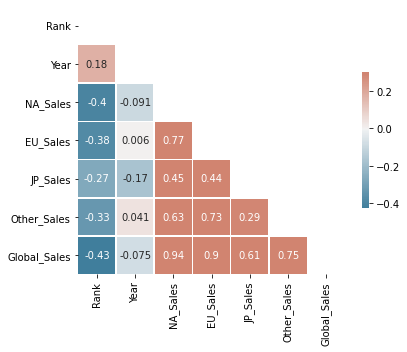

In [8]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool)) # Obtaining the superior triangular matrix

f, ax = plt.subplots(figsize=(6, 5)) # Setting the figure size
cmap = sns.diverging_palette(230, 20, as_cmap=True) # Setting the color palette of the correlation matrix

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=0.5, cbar_kws={'shrink': 0.5}, annot=True);

The correlation is very high in NA, EU, JP and Other Sales with Global_Sales, it can affect the supervised algorithm  when fitting the model and interpret the results maybe it can cause overfitting due to this. But the columns are necesary to predict the global sales so those columns will not be droped out

___
**Filling the missing values**

In [9]:
# Checking missing values
df.isna().sum()

Rank              0
Name              0
Platform          0
Year            271
Genre             0
Publisher        58
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
Global_Sales      0
dtype: int64

The *Year* column will be filled with a forward fill and for the *Publisher* column we will use the statistic mode

In [10]:
df['Year'].fillna(method='ffill', inplace=True) # Forward filling the Year NA values
df['Publisher'].fillna(df['Publisher'].mode()[0], inplace=True) # Filling the Publisher NA values with the statistic mode

# Checking if there are missing values
print('Missing values: {}'.format(df.isna().sum().sum()))

Missing values: 0


In [11]:
df['Year'] = df['Year'].astype(np.int64) # Changing Year dtype to int as a convention

In [12]:
df.dtypes # Checking all the column dtypes are correct

Rank              int64
Name             object
Platform         object
Year              int64
Genre            object
Publisher        object
NA_Sales        float64
EU_Sales        float64
JP_Sales        float64
Other_Sales     float64
Global_Sales    float64
dtype: object

___
**Selecting the columns for the Supervised Machine Learing algorithm**

In [13]:
dataset = df.copy() # Making a copy of the dataset as a good practice
dataset.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [14]:
# Checking the unique values of the columns to make a decision on wich ones 
# to use for the regression model
for i in dataset.columns:
  print(f'''{i} - unique values: {len(dataset[i].unique())}
               dtype: {dataset[i].dtype}''')

Rank - unique values: 16598
               dtype: int64
Name - unique values: 11493
               dtype: object
Platform - unique values: 31
               dtype: object
Year - unique values: 39
               dtype: int64
Genre - unique values: 12
               dtype: object
Publisher - unique values: 578
               dtype: object
NA_Sales - unique values: 409
               dtype: float64
EU_Sales - unique values: 305
               dtype: float64
JP_Sales - unique values: 244
               dtype: float64
Other_Sales - unique values: 157
               dtype: float64
Global_Sales - unique values: 623
               dtype: float64


The columns *Rank, Name* and *Publisher* will cause problems for regression as multiple string values so we will drop them.
The *Platform* and *Genre* column will be one hot encoded

In [15]:
# Removing the problematic columns
dataset.drop(['Rank', 'Name', 'Publisher'], axis=1, inplace=True)

In [16]:
# Separating categorical columns and numeric columns for further processing
cat_cols = ['Platform', 'Genre']
num_cols = ['Year', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']

Sparating predictor variables (X) and objective (y) and dividing the training and testing sets

In [17]:
# Processing the data
X = dataset.drop('Global_Sales', axis=1) # Predictor variables
y = dataset['Global_Sales'] # Objective variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [18]:
transformer = make_column_transformer((RobustScaler(), num_cols),
                                      (OneHotEncoder(handle_unknown='ignore'), cat_cols))
transformer.fit(X_train)

X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

**Defining the best parameters for the models**

**Linear Regression**

In [19]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

r_sq = lr.score(X_test, y_test)
print('R^2: {:.2f}'.format(r_sq))
print('MAE: {:.2f}'.format(mean_absolute_error(y_test, y_pred)))
print('RMSE: {:.2f}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))
print('R^2 with all decimals:', r2_score(y_test, y_pred)*100)

R^2: 1.00
MAE: 0.00
RMSE: 0.01
R^2 with all decimals: 99.99934762391172


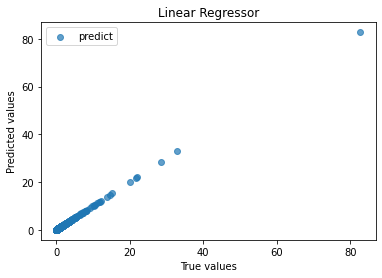

In [20]:
plt.scatter(y_test, y_pred, alpha=0.7, label='predict')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Linear Regressor')
plt.legend()
plt.show();

As we suspected the LinearRegression model presents overfitting so it is not reliable for predictions?

+ $R^2$: The model have an accuracy of 99.99% it may be overfitted and this could be not very reliable
+ MAE:
+ RMSE:

**Decision Regressor Tree**

In [21]:
grid_param = {'max_depth': [i for i in range(1, 16)]}

grid = GridSearchCV(DecisionTreeRegressor(), grid_param)
grid.fit(X_train, y_train)
grid.best_params_

{'max_depth': 14}

In [22]:
dtr = DecisionTreeRegressor(max_depth=list(grid.best_params_.values())[0])
dtr.fit(X_train, y_train)
y_pred = dtr.predict(X_test)

r_sq = dtr.score(X_test, y_test)
print('R^2: {:.2f}'.format(r_sq))
print('MAE: {:.2f}'.format(mean_absolute_error(y_test, y_pred)))
print('RMSE: {:.2f}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))

R^2: 0.85
MAE: 0.06
RMSE: 0.78


In [23]:
dot_data = export_graphviz(dtr,
                           filled=True)

tree_plot = graph.Source(dot_data, format="png") 
tree_plot

In [24]:
# The tree with a zoom out
# from sklearn import tree
# fig = plt.figure(figsize=(12, 12))
# _ = tree.plot_tree(dtr,
#                    filled=True)

+ $R^2$: The model is a 85% acurate and is considerably good
+ MAE:
+ RMSE:

**Support Vector Machine for Regression**

In [25]:
svr = SVR(kernel='linear', epsilon=0.75)
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)

r_sq = svr.score(X_test, y_test)
print('R^2: {:.2f}'.format(r_sq))
print('MAE: {:.2f}'.format(mean_absolute_error(y_test, y_pred)))
print('RMSE: {:.2f}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))

R^2: 0.92
MAE: 0.56
RMSE: 0.57


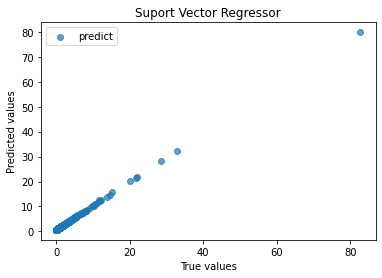

In [26]:
plt.scatter(y_test, y_pred, alpha=0.7, label='predict')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Suport Vector Regressor')
plt.legend()
plt.show();

+ $R^2$: The model presents a 92% accuray is looks like a pretty good model.
+ MAE:
+ RMSE:

___
# Conclusions

